In [1]:
import numpy as np
import pandas as pd
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#  save the figures
Project_Root_Directory = "."
Section_Id             = "Classification"
Images_Path            = os.path.join(Project_Root_Directory, "images", Section_Id)
os.makedirs(Images_Path, exist_ok =True)

def save_pictures(fig_id, tight_layout =True, fig_extension ="png", resolution = 300):
    path = os.path.join(Images_Path, fig_id+ "."+ fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)
    

# MNIST Data set
- MNIST dataset contains images of digits handwritten. Each image is labeled with the digit it represents. 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) #  fetches the MNIST dataset
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
display(X.shape)   # 70,000 images, and each image has 784 features
display(y.shape)

(70000, 784)

(70000,)

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28) # each image is 28 × 28 pixels
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Exact solution:  9


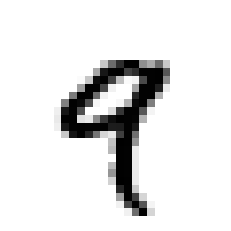

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

k = 4
plot_digit(X[k])
print("Exact solution: ", y[k])

In [6]:
# cast y to integer
y = y.astype(np.uint8)

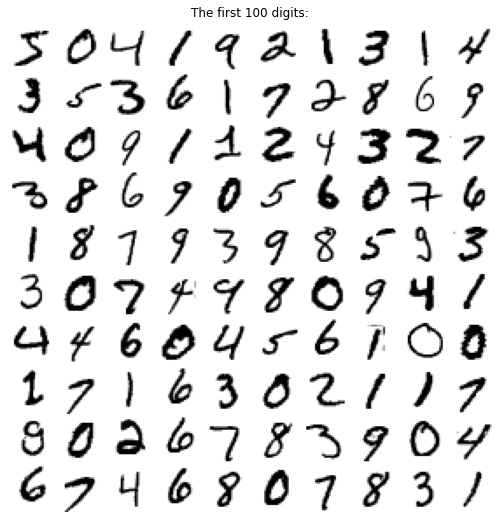

In [7]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.title("The first 100 digits: ")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

In [9]:
# Extracting image number 6
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

In [10]:
# Stochastic Gradient Descent (SGD) classifier: the advantage of being capable of handling very large datasets efficiently
# The SGDClassifier relies on randomness during training 
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(random_state=42)

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring="accuracy") #Showing above 98 

array([0.9829 , 0.98025, 0.9804 ])

In [12]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_6):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_6[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_6[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.94635
0.98085
0.98335


## Confusion Matrix

- To evaluate the performance of a classifier.
- How it works: counting the number of times instances of class A are classified as calss B.
- To compute: set of predictions is compared to the actual targets. 

In [13]:
from sklearn.model_selection import cross_val_predict
# returns the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3) # performs K-fold cross-validation; 


- row in a confusion matrix represents an actual class
- while each column represents a predicted class

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_6, y_train_pred)
print(cm)
print("*---------------------------------------------------------------*")
print("The negative class (non-6 images):" ,cm[0, 0])
print("The true class (correctly classified as non-6 images):" ,cm[0, 1])
print("The false possitive class (were wrongly classified as non-6 images):" ,cm[1, 0])
print("The positive class (correctly classified as 6 images):" ,cm[1, 1])

[[53562   520]
 [  609  5309]]
*---------------------------------------------------------------*
The negative class (non-6 images): 53562
The true class (correctly classified as non-6 images): 520
The false possitive class (were wrongly classified as non-6 images): 609
The positive class (correctly classified as 6 images): 5309


In [15]:
# A perfect classifier would have only true positives and true negatives, 
# so its confusion matrix would have nonzero values only on its main diagonal 
y_train_perfect_predictions = y_train_6  # pretend we reached perfection
confusion_matrix(y_train_6, y_train_perfect_predictions)

array([[54082,     0],
       [    0,  5918]], dtype=int64)

# Precision and Recall

In [16]:
# Import classification metrics, including percision and recall:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_6, y_train_pred) # seems good: 91,07% accuracy

0.9107908732201063

In [17]:
recall_score(y_train_6, y_train_pred) # it detected 89,71% of the 6s

0.8970936127069956

In [18]:
# F1 score is haemonic mean of percision and recall; Whereas the regular mean
# treats all values equally, the harmonic mean gives much more weight to low values
from sklearn.metrics import f1_score
# F1 score favors classifiers that have similar precision and recall
f1_score(y_train_6, y_train_pred)

0.9038903549842513

## Precision/Recall Trade - off


In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3,
                             method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

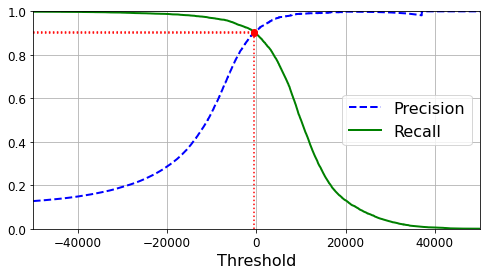

In [22]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

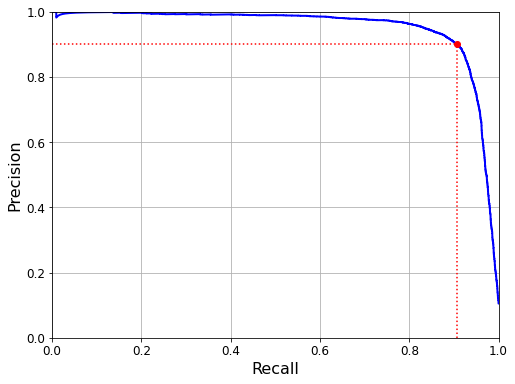

In [23]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-571.059702694004

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_6, y_train_pred_90)

0.9000670690811536

In [26]:
recall_score(y_train_6, y_train_pred_90)

0.9070631970260223

#  The receiver operating characteristic (ROC) curve
- Useful tool in binary classifiers
- The ROC curve plots the true possive rate (recall) vs the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as possitive. 
- It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative.
- The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

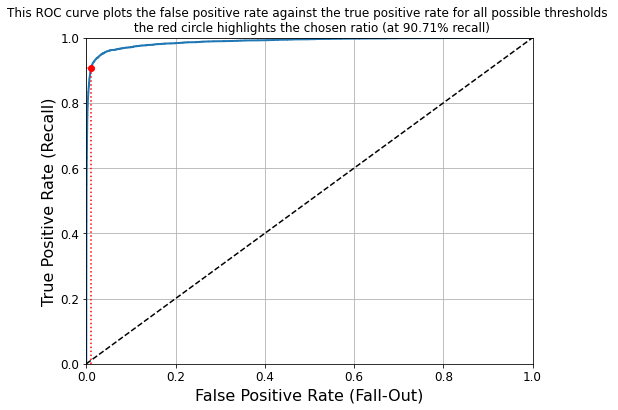

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")   
plt.title("This ROC curve plots the false positive rate against the true positive rate for all possible thresholds \n the red circle highlights the chosen ratio (at {:.2f}% recall)".format(100*recall_90_precision))
plt.show()

There is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

# Measure the area under the curve (AUC)
- A perfect classifier will have a ROC AUC equal to 1
- a purely random classifier will have a ROC AUC equal to 0.5

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6, y_scores)

0.9878749264865954

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_6, cv=3,
                                    method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6,y_scores_forest)

Comparing ROC curves: the Random Forest classifier is superior to the SGD
classifier because its ROC curve is much closer to the top-left corner, and it has a greater
AUC

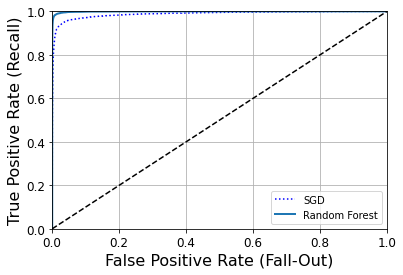

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
roc_auc_score(y_train_6, y_scores_forest)

0.9991551090374211

grid_search.best_params_

grid_search.best_score_

In [ ]:

from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)